In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader
from modules.constants import feature_list
from modules.data import GapFillingDataset
from modules.mlp import MLP
from modules.baseline import Baseline
from modules.gapt import GapT

In [12]:
seq_len = 'four_week' # 'four_week'

os.makedirs(f'results/{seq_len}', exist_ok=True)

In [13]:
output_dir = f'results/mlp_{seq_len}_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    mlp_metadata = json.load(f)

# Extract arguments from metadata
args = mlp_metadata['args']

# Initialize model from checkpoint
mlp = MLP.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    d_output=args['d_output'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/mlp_four_week_seq/model.ckpt`


In [14]:
output_dir = f'results/baseline_{seq_len}_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    baseline_metadata = json.load(f)

# Extract arguments from metadata
args = baseline_metadata['args']

# Initialize model from checkpoint
baseline = Baseline.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'], 
    d_model=args['d_model'], 
    d_output=args['d_output'],
    d_embedding=args['d_embedding'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/baseline_four_week_seq/model.ckpt`


In [15]:
output_dir = f'results/gapt_naive_{seq_len}_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    gapt_naive_metadata = json.load(f)

# Extract arguments from metadata
args = gapt_naive_metadata['args']

# Initialize model from checkpoint
gapt_naive = GapT.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'],
    d_feedforward=args['d_feedforward'],
    d_model=args['d_model'], 
    n_layers=args['n_layers'], 
    d_output=args['d_output'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
    mode=args['mode'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/gapt_naive_four_week_seq/model.ckpt`


In [16]:
output_dir = f'results/gapt_default_{seq_len}_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    gapt_metadata = json.load(f)

# Extract arguments from metadata
args = gapt_metadata['args']

# Initialize model from checkpoint
gapt = GapT.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'],
    d_feedforward=args['d_feedforward'],
    d_model=args['d_model'], 
    n_layers=args['n_layers'], 
    d_output=args['d_output'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
    mode=args['mode'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/gapt_default_four_week_seq/model.ckpt`


In [17]:
with open(os.path.join(args['data_dir'], 'paths.json'), 'r') as f:
    data_paths = json.load(f)

test_dataset = GapFillingDataset(data_paths['test'], gapt_metadata['feature_list'])
torch.manual_seed(42)
test_dataloader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)

### Calculate metrics

In [36]:
# Set models to eval mode
mlp.eval()
baseline.eval()
gapt_naive.eval()
gapt.eval()

# Initialize Error Accumulators
baseline_mse_errors = []
gapt_naive_mse_errors = []
gapt_mse_errors = []
mlp_mse_errors = []

baseline_rmse_errors = []
gapt_naive_rmse_errors = []
gapt_rmse_errors = []
mlp_rmse_errors = []

baseline_mae_errors = []
gapt_naive_mae_errors = []
gapt_mae_errors = []
mlp_mae_errors = []

baseline_mbe_errors = []
gapt_naive_mbe_errors = []
gapt_mbe_errors = []
mlp_mbe_errors = []

# Loop over batches
for batch in tqdm(test_dataloader):
    
    with torch.no_grad():
        baseline_predictions = baseline(batch)
        gapt_naive_predictions = gapt_naive(batch)
        gapt_predictions = gapt(batch)
        mlp_predictions = mlp(batch)
    
    target = batch['target'].cpu().detach().numpy()
    baseline_predictions = baseline_predictions.cpu().detach().numpy()
    gapt_naive_predictions = gapt_naive_predictions.cpu().detach().numpy()
    gapt_predictions = gapt_predictions.cpu().detach().numpy()
    mlp_predictions = mlp_predictions.cpu().detach().numpy()
    mask = batch['mask'].cpu().detach().numpy()
    covariates = batch['covariates'].cpu().detach().numpy()
    file = batch['file']
    
    inverted_mask = ~mask

    for idx in range(target.shape[0]):      
        true_values = np.exp(target[idx][inverted_mask[idx]])
        
        baseline_pred = np.exp(baseline_predictions[idx][inverted_mask[idx]])
        gapt_naive_pred = np.exp(gapt_naive_predictions[idx][inverted_mask[idx]])
        gapt_pred = np.exp(gapt_predictions[idx][inverted_mask[idx]])
        mlp_pred = np.exp(mlp_predictions[idx][inverted_mask[idx]])
        
        # Accumulate RMSE errors
        baseline_rmse_errors.append(np.sqrt(mean_squared_error(true_values, baseline_pred)))
        gapt_naive_rmse_errors.append(np.sqrt(mean_squared_error(true_values, gapt_naive_pred)))
        gapt_rmse_errors.append(np.sqrt(mean_squared_error(true_values, gapt_pred)))
        mlp_rmse_errors.append(np.sqrt(mean_squared_error(true_values, mlp_pred)))

        # Accumulate MAE errors
        baseline_mae_errors.append(mean_absolute_error(true_values, baseline_pred))
        gapt_naive_mae_errors.append(mean_absolute_error(true_values, gapt_naive_pred))
        gapt_mae_errors.append(mean_absolute_error(true_values, gapt_pred))
        mlp_mae_errors.append(mean_absolute_error(true_values, mlp_pred))

        # Accumulate MBE errors
        baseline_mbe_errors.append(np.mean(baseline_pred - true_values))
        gapt_naive_mbe_errors.append(np.mean(gapt_naive_pred - true_values))
        gapt_mbe_errors.append(np.mean(gapt_pred - true_values))
        mlp_mbe_errors.append(np.mean(mlp_pred - true_values))

  0%|          | 0/128 [00:00<?, ?it/s]

In [37]:
# Calculate RMSE Mean and Std
baseline_rmse_mean, baseline_rmse_std = np.mean(baseline_rmse_errors), np.std(baseline_rmse_errors)
gapt_naive_rmse_mean, gapt_naive_rmse_std = np.mean(gapt_naive_rmse_errors), np.std(gapt_naive_rmse_errors)
gapt_rmse_mean, gapt_rmse_std = np.mean(gapt_rmse_errors), np.std(gapt_rmse_errors)
mlp_rmse_mean, mlp_rmse_std = np.mean(mlp_rmse_errors), np.std(mlp_rmse_errors)

# Calculate MAE Mean and Std
baseline_mae_mean, baseline_mae_std = np.mean(baseline_mae_errors), np.std(baseline_mae_errors)
gapt_naive_mae_mean, gapt_naive_mae_std = np.mean(gapt_naive_mae_errors), np.std(gapt_naive_mae_errors)
gapt_mae_mean, gapt_mae_std = np.mean(gapt_mae_errors), np.std(gapt_mae_errors)
mlp_mae_mean, mlp_mae_std = np.mean(mlp_mae_errors), np.std(mlp_mae_errors)

# Calculate MBE Mean and Std
baseline_mbe_mean, baseline_mbe_std = np.mean(baseline_mbe_errors), np.std(baseline_mbe_errors)
gapt_naive_mbe_mean, gapt_naive_mbe_std = np.mean(gapt_naive_mbe_errors), np.std(gapt_naive_mbe_errors)
gapt_mbe_mean, gapt_mbe_std = np.mean(gapt_mbe_errors), np.std(gapt_mbe_errors)
mlp_mbe_mean, mlp_mbe_std = np.mean(mlp_mbe_errors), np.std(mlp_mbe_errors)

# Print RMSE results
print('MLP RMSE:', mlp_rmse_mean, 'Std:', mlp_rmse_std)
print('Baseline RMSE:', baseline_rmse_mean, 'Std:', baseline_rmse_std)
print('Gapt (naive) RMSE:', gapt_naive_rmse_mean, 'Std:', gapt_naive_rmse_std)
print('Gapt RMSE:', gapt_rmse_mean, 'Std:', gapt_rmse_std)
print('-----------------------------')
# Print MAE results
print('MLP MAE:', mlp_mae_mean, 'Std:', mlp_mae_std)
print('Baseline MAE:', baseline_mae_mean, 'Std:', baseline_mae_std)
print('Gapt (naive) RMSE:', gapt_naive_mae_mean, 'Std:', gapt_naive_mae_std)
print('Gapt MAE:', gapt_mae_mean, 'Std:', gapt_mae_std)
print('-----------------------------')
# Print MBE results
print('MLP MAE:', mlp_mbe_mean, 'Std:', mlp_mbe_std)
print('Baseline MBE:', baseline_mbe_mean, 'Std:', baseline_mbe_std)
print('Gapt (naive) RMSE:', gapt_naive_mbe_mean, 'Std:', gapt_naive_mbe_std)
print('Gapt MBE:', gapt_mbe_mean, 'Std:', gapt_mbe_std)

MLP RMSE: 550.8439 Std: 602.6949
Baseline RMSE: 480.34766 Std: 546.54285
Gapt (naive) RMSE: 449.27356 Std: 523.9119
Gapt RMSE: 432.50723 Std: 509.325
-----------------------------
MLP MAE: 448.7197 Std: 482.2724
Baseline MAE: 371.56552 Std: 419.41824
Gapt (naive) RMSE: 345.8732 Std: 398.04868
Gapt MAE: 330.45496 Std: 383.34308
-----------------------------
MLP MAE: -14.582689 Std: 571.2499
Baseline MBE: -133.5048 Std: 421.69614
Gapt (naive) RMSE: -90.78267 Std: 409.4173
Gapt MBE: -78.484116 Std: 386.398


In [18]:
# Set models to eval mode
mlp.eval()
baseline.eval()
gapt_naive.eval()
gapt.eval()

# Initialize a dictionary to store metrics per key
metrics_by_key = defaultdict(lambda: defaultdict(list))

# Loop over batches
for batch in tqdm(test_dataloader):
    
    with torch.no_grad():
        mlp_predictions = mlp(batch)
        baseline_predictions = baseline(batch)
        gapt_naive_predictions = gapt_naive(batch)
        gapt_predictions = gapt(batch)
    
    target = batch['target'].cpu().detach().numpy()
    baseline_predictions = baseline_predictions.cpu().detach().numpy()
    gapt_predictions = gapt_predictions.cpu().detach().numpy()
    mlp_predictions = mlp_predictions.cpu().detach().numpy()
    gapt_naive_predictions = gapt_naive_predictions.cpu().detach().numpy()
    mask = batch['mask'].cpu().detach().numpy()
    file = batch['file']
    
    inverted_mask = ~mask

    for idx in range(target.shape[0]):
        key = file[idx].split('/')[-1].split('.')[0].split('_')[0]
        true_values = np.exp(target[idx][inverted_mask[idx]])
        
        baseline_pred = np.exp(baseline_predictions[idx][inverted_mask[idx]])
        gapt_pred = np.exp(gapt_predictions[idx][inverted_mask[idx]])
        mlp_pred = np.exp(mlp_predictions[idx][inverted_mask[idx]])
        gapt_naive_pred = np.exp(gapt_naive_predictions[idx][inverted_mask[idx]])

        # Accumulate errors by key       
        metrics_by_key[key]['baseline_rmse'].append(np.sqrt(mean_squared_error(true_values, baseline_pred)))
        metrics_by_key[key]['gapt_naive_rmse'].append(np.sqrt(mean_squared_error(true_values, gapt_naive_pred)))
        metrics_by_key[key]['gapt_rmse'].append(np.sqrt(mean_squared_error(true_values, gapt_pred)))
        metrics_by_key[key]['mlp_rmse'].append(np.sqrt(mean_squared_error(true_values, mlp_pred)))
        
        metrics_by_key[key]['mlp_mae'].append(mean_absolute_error(true_values, mlp_pred))
        metrics_by_key[key]['baseline_mae'].append(mean_absolute_error(true_values, baseline_pred))
        metrics_by_key[key]['gapt_naive_mae'].append(mean_absolute_error(true_values, gapt_naive_pred))
        metrics_by_key[key]['gapt_mae'].append(mean_absolute_error(true_values, gapt_pred))

        metrics_by_key[key]['mlp_mbe'].append(np.mean(mlp_pred - true_values))
        metrics_by_key[key]['baseline_mbe'].append(np.mean(baseline_pred - true_values))
        metrics_by_key[key]['gapt_naive_mbe'].append(np.mean(gapt_naive_pred - true_values))
        metrics_by_key[key]['gapt_mbe'].append(np.mean(gapt_pred - true_values))        

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
results_by_key = {}
for key, metrics in tqdm(metrics_by_key.items()):
    results_by_key[key] = {}
    for metric_name, values in metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        results_by_key[key][metric_name + '_mean'] = float(mean_val)
        results_by_key[key][metric_name + '_std'] = float(std_val)

  0%|          | 0/31 [00:00<?, ?it/s]

In [20]:
with open(f'results/{seq_len}/station_metrics.json', 'w') as f:
    json.dump(results_by_key, f, indent=4)

### Plot comparisons

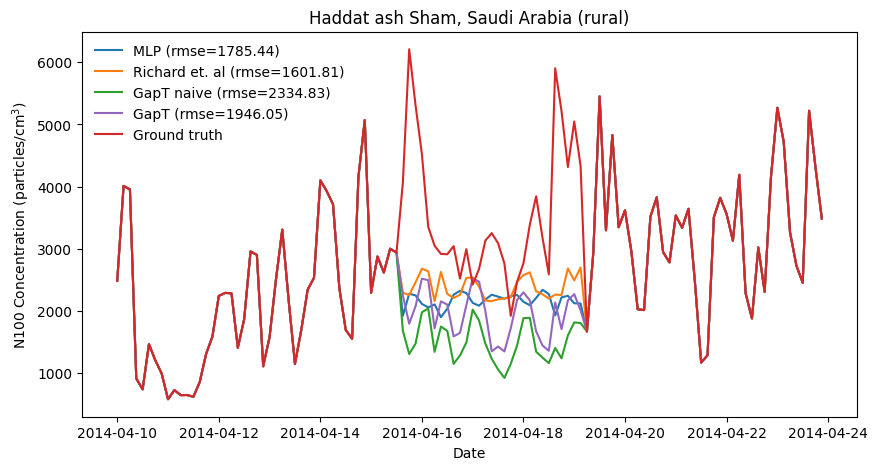

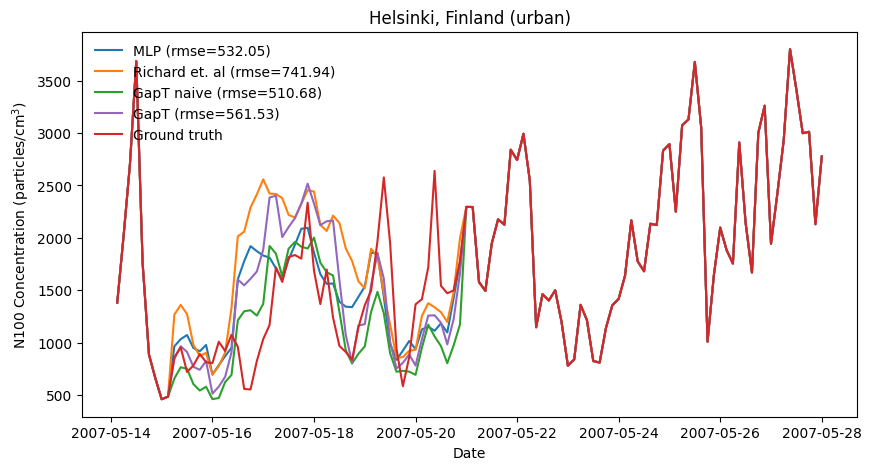

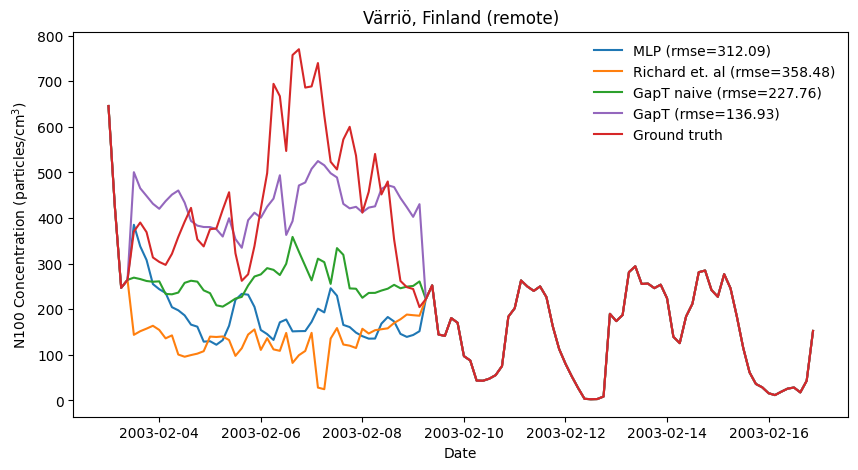

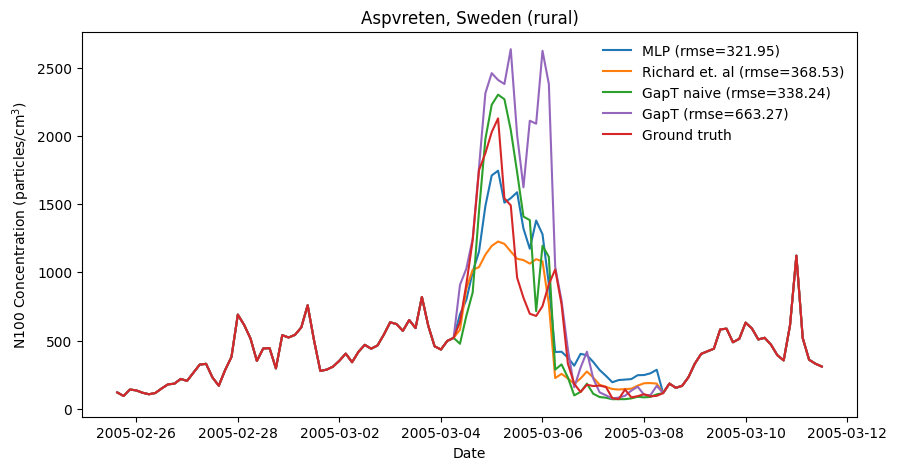

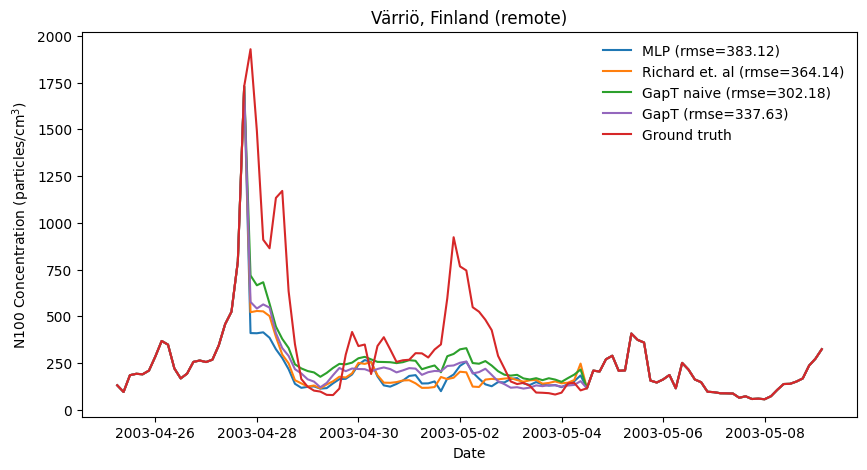

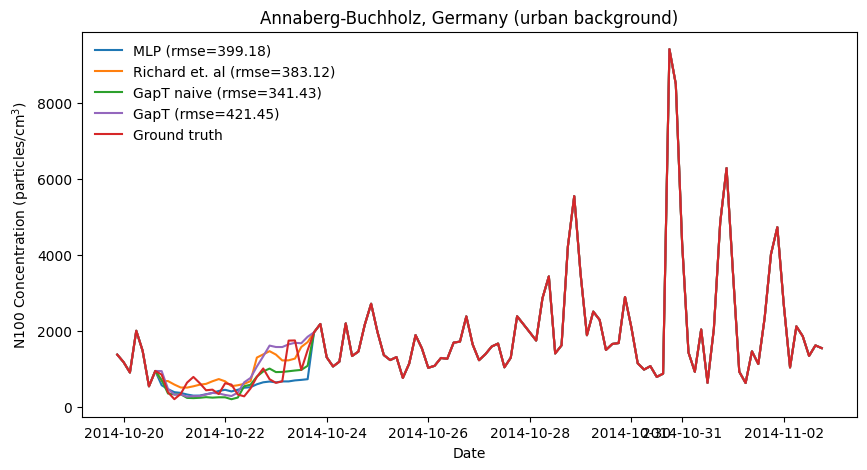

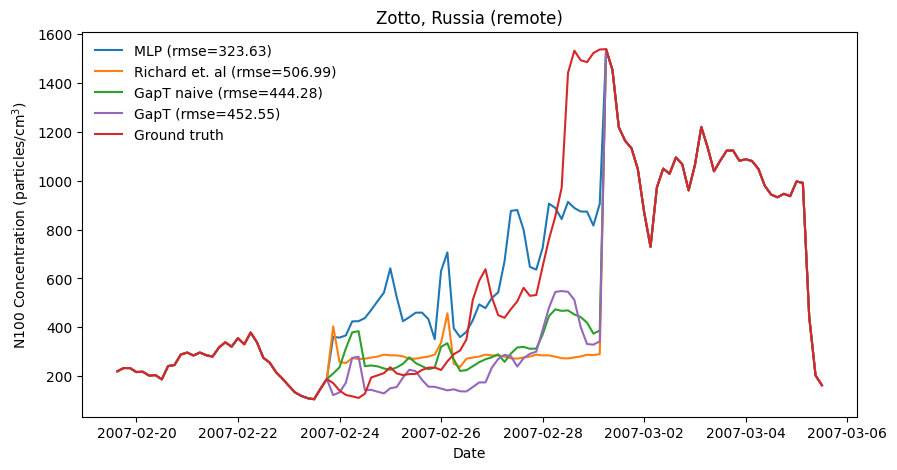

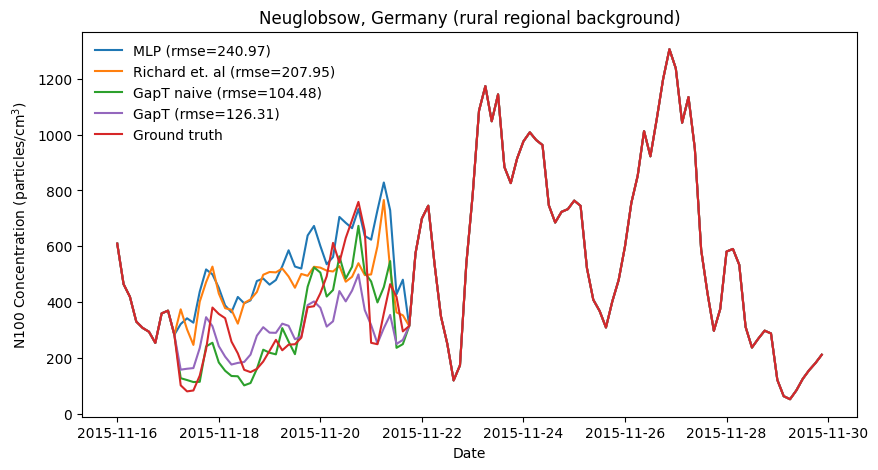

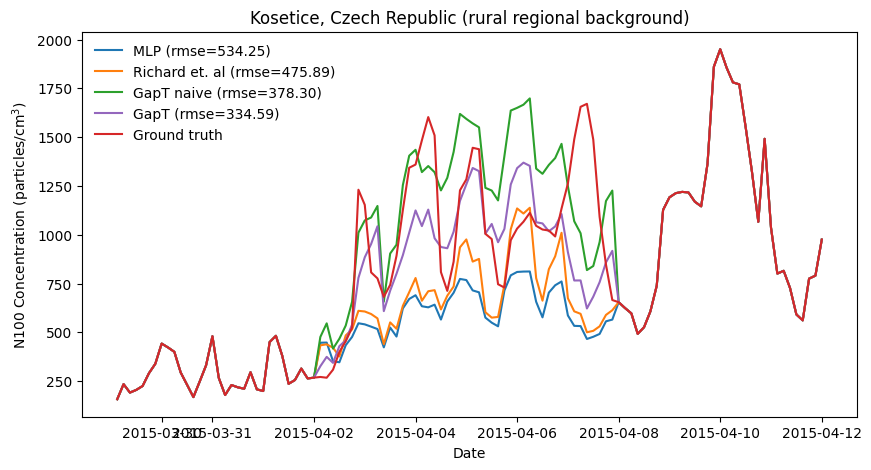

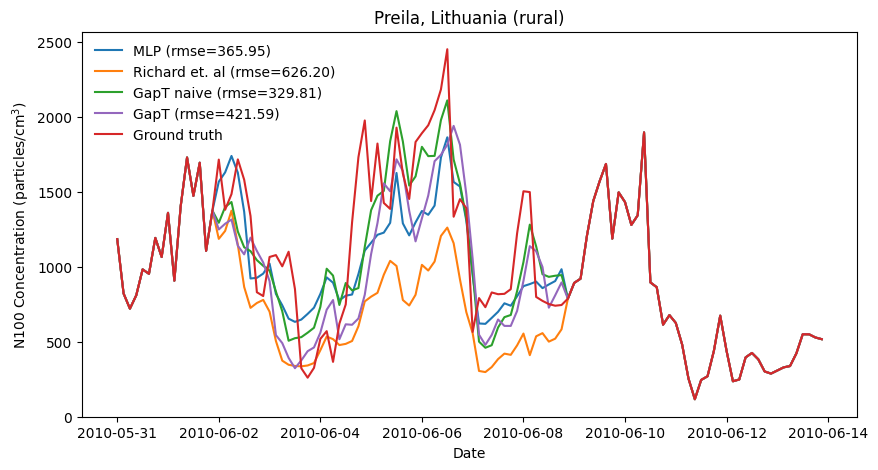

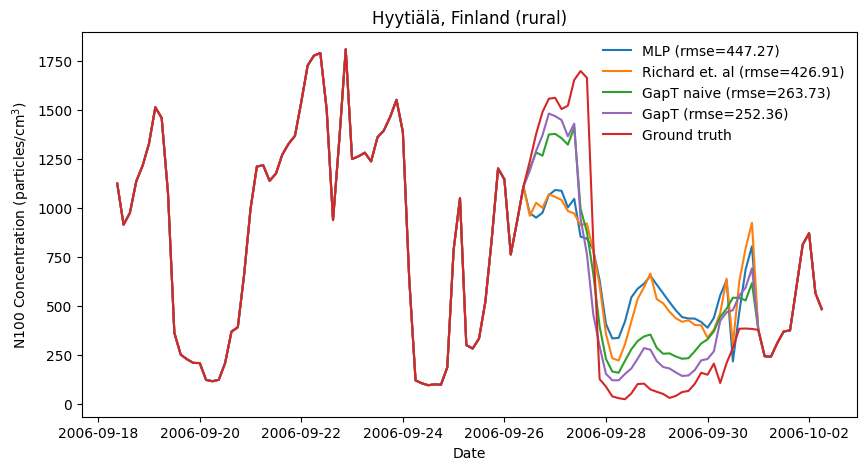

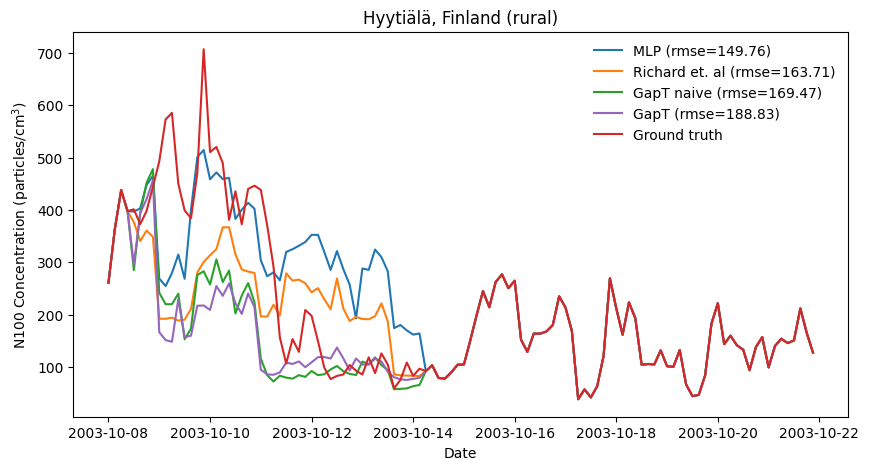

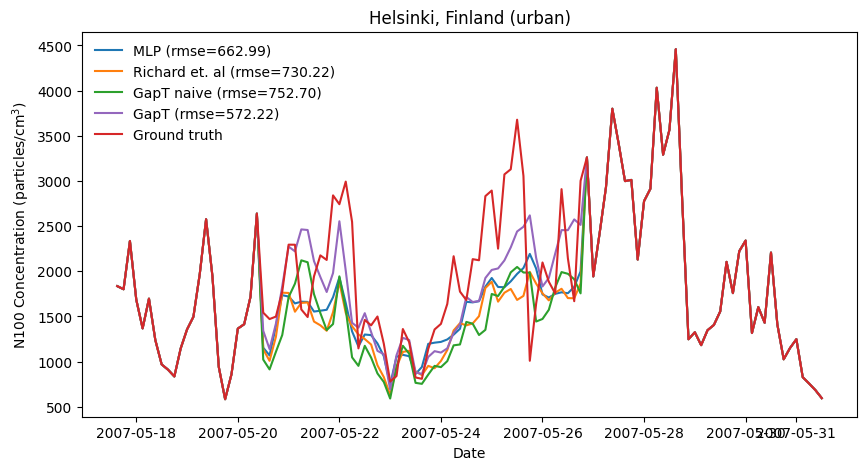

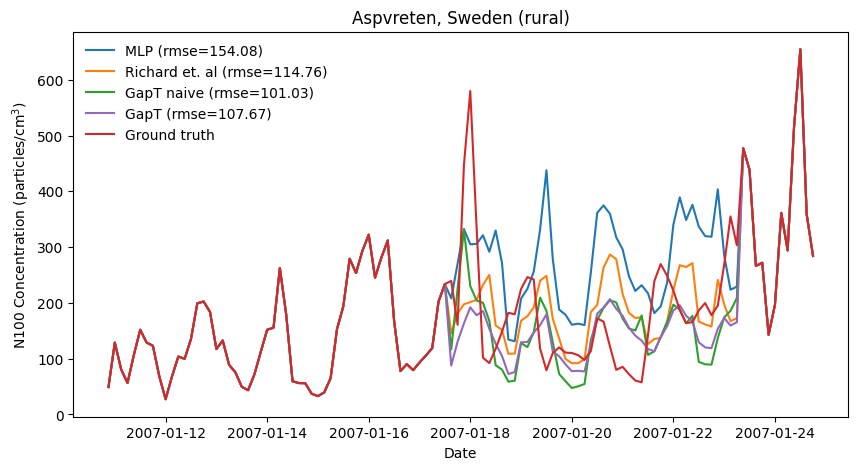

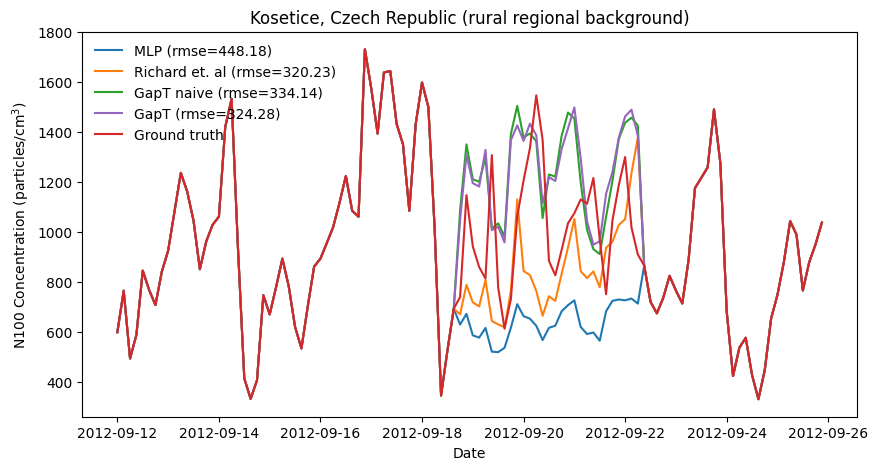

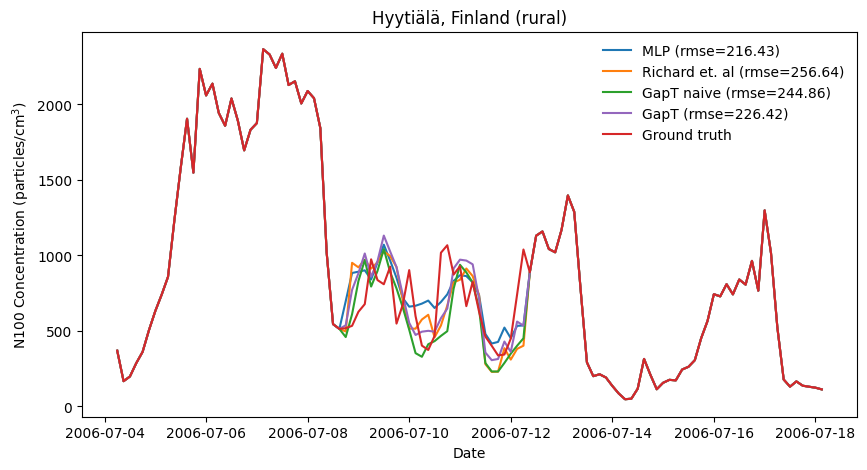

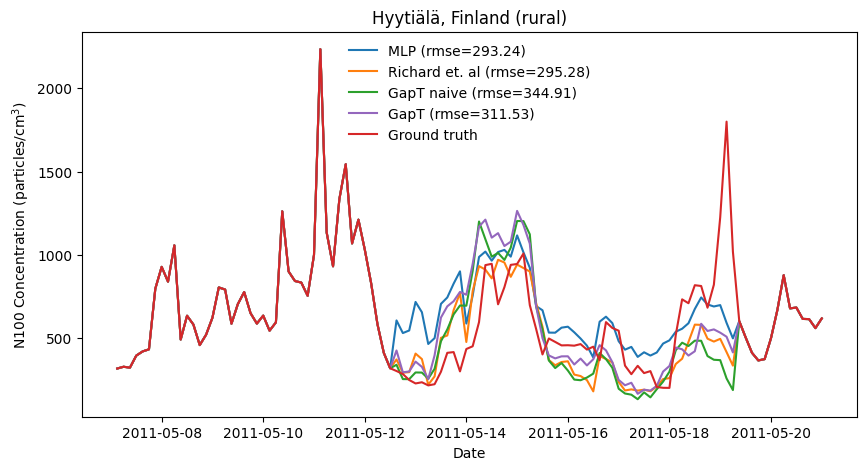

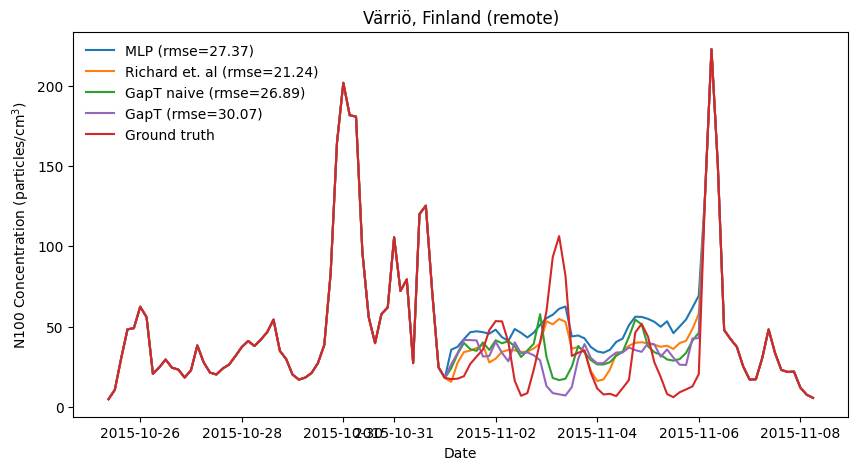

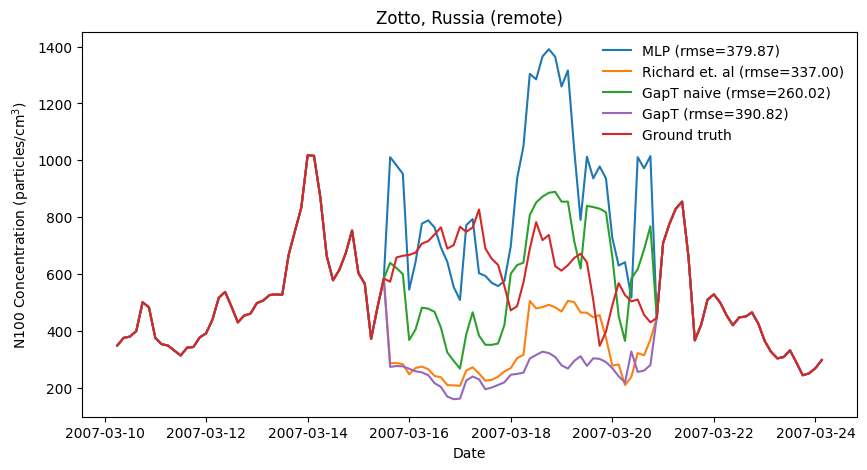

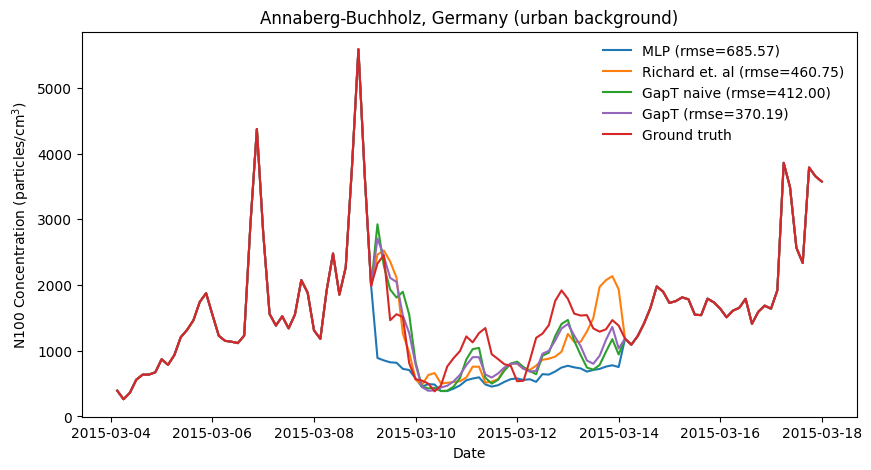

In [22]:
mlp.eval()
baseline.eval()
gapt_naive.eval()
gapt.eval()

with open('data/measurement_sites.json', 'r') as file:
    measurement_sites = pd.read_json(file)

for batch in test_dataloader:
    
    with torch.no_grad():
        mlp_predictions = np.exp(mlp(batch))
        baseline_predictions = np.exp(baseline(batch))
        gapt_naive_predictions = np.exp(gapt_naive(batch))
        gapt_predictions = np.exp(gapt(batch))
    
    date = batch['unix_date']
    mask = batch['mask']
    target = np.exp(batch['target'])
    file = batch['file']
    
    inverted_mask = ~mask

    for idx in range(0, 20):
        mlp_rmse = np.sqrt(mean_squared_error(target[idx][inverted_mask[idx]], mlp_predictions[idx][inverted_mask[idx]]))
        baseline_rmse = np.sqrt(mean_squared_error(target[idx][inverted_mask[idx]], baseline_predictions[idx][inverted_mask[idx]]))
        gapt_naive_rmse = np.sqrt(mean_squared_error(target[idx][inverted_mask[idx]], gapt_naive_predictions[idx][inverted_mask[idx]]))
        gapt_rmse = np.sqrt(mean_squared_error(target[idx][inverted_mask[idx]], gapt_predictions[idx][inverted_mask[idx]]))
    
        sample_date = pd.to_datetime(date[idx], unit='s')
        
        gap_indices = np.where(mask[idx] == False)
        
        key = file[idx].split('/')[-1].split('.')[0].split('_')[0]
        station_name = measurement_sites[key]['station_name']
        environment_type = ' '.join(measurement_sites[key]['environment_type'].split('_'))

        plt.figure(figsize=(10, 5))
        plt.plot(sample_date, mlp_predictions[idx], label=f'MLP (RMSE={mlp_rmse:.2f})', c='tab:blue')
        plt.plot(sample_date, baseline_predictions[idx], label=f'Richard et al. (RMSE={baseline_rmse:.2f})', c='tab:orange')
        plt.plot(sample_date, gapt_naive_predictions[idx], label=f'GapT naive (RMSE={gapt_naive_rmse:.2f})', c='tab:green')
        plt.plot(sample_date, gapt_predictions[idx], label=f'GapT (RMSE={gapt_rmse:.2f})', c='tab:purple')
        plt.plot(sample_date, target[idx], label='Ground truth', c='tab:red')
        plt.xlabel('Date')
        plt.ylabel(r'N100 Concentration (particles/cm$^3$)')
        plt.title(f'{station_name} ({environment_type})')
        plt.legend(frameon=False)
        plt.show()

    break